In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
import sqlite3
import shapefile as shp
import seaborn as sns
import unicodedata
from IPython.display import Markdown, display
import geopandas as gpd
import warnings
# use for chloropleth map's warnings on nan values in geopandas dataset
warnings.filterwarnings('ignore')

%matplotlib inline

## Preprocessing

Data more often than not do not come in ready readable format. In order to make this data more understandable to us, a bit of massaging is necessary. First and foremost the language in which the data are stored is Czech, so we need to write a series of functions to translate those columns. Additionally, our data exist in our database in particular tables, on which we'll need to join to attempt to ascertain meaningful information. Below are that process: 

In [2]:
conn = sqlite3.connect('../data/financial.db')

In [3]:
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('account',), ('card',), ('client',), ('disp',), ('district',), ('loan',), ('order',), ('trans',)]


In [4]:
accountDF = pd.read_sql_query("SELECT * FROM account", conn)
cardDF = pd.read_sql_query("SELECT * FROM card", conn)
clientDF = pd.read_sql_query("SELECT * FROM client", conn)
dispositionDF = pd.read_sql_query("SELECT * FROM disp", conn)
districtDF = pd.read_sql_query("SELECT * FROM district", conn)
loanDF = pd.read_sql_query("SELECT * FROM loan", conn)
orderDF = pd.read_sql_query("SELECT * FROM \"order\"", conn)
transDF = pd.read_sql_query("SELECT * FROM trans", conn)
conn.close()

In [5]:
def updateFrequency(freq): 
    if freq == 'POPLATEK MESICNE': return 'Monthly'
    if freq == 'POPLATEK TYDNE': return 'Weekly'
    if freq == 'POPLATEK PO OBRATU': return 'AfterTransaction'
    
def updateKSymbol(kSym): 
    if kSym == 'POJISTNE': return 'Insurance'
    if kSym == 'SIPO': return 'Household'
    if kSym == 'LEASING': return 'Leasing'
    if kSym == 'UVER': return 'Loan'
    if kSym == 'SLUZBY': return 'Statement'
    if kSym == 'UROK': return 'Interest Credited'
    if kSym == 'SANKC. UROK': return 'Sanction Interest if Negative Balance'
    if kSym == 'DUCHOD': return 'Old Age Pension'

def updateType(transactionType): 
    if transactionType == 'PRIJEM': return 'Credit'
    if transactionType == 'VYDAJ': return 'Withdrawal'
    
def updateOperation(mode): 
    if mode == 'VYBER KARTOU': return 'Credit Card Withdrawal'
    if mode == 'VKLAD': return 'Credit in Cash'
    if mode == 'PREVOD Z UCTU': return 'Collection from another Bank'
    if mode == 'VYBER': return 'Withdrawal in Cash'
    if mode == 'PREVOD NA UCET': return 'Remittance to Another Bank'

def updateAccountStatus(status): 
    if status == 'A': return 'Finished: No Problems'
    if status == 'B': return 'Finished: Loan Not Payed'
    if status == 'C': return 'Running: OK'
    if status == 'D': return 'Running: In Debt'
    
def printmd(string):
    display(Markdown(string))

In [6]:
englishAccountDF = pd.DataFrame.copy(accountDF)
englishAccountDF['frequency'] = accountDF['frequency'].apply(lambda x: updateFrequency(x))

englishOrderDF =  pd.DataFrame.copy(orderDF)
englishOrderDF['k_symbol'] = orderDF['k_symbol'].apply(lambda x: updateKSymbol(x))

englishTransDF = pd.DataFrame.copy(transDF)
englishTransDF['type'] =  transDF['type'].apply(lambda x: updateType(x))
englishTransDF['operation'] =  transDF['operation'].apply(lambda x: updateOperation(x))
englishTransDF['k_symbol'] =  transDF['k_symbol'].apply(lambda x: updateOperation(x))

englishLoanDF  =  pd.DataFrame.copy(loanDF)
englishLoanDF['status'] = loanDF['status'].apply(lambda x: updateAccountStatus(x))

## Discussion of  Data

The blow are all brief illustrations of the data within the sqlite tables. Note, however, that any Czech have been translated to their corresponding English meaning as per the data description. 

In [7]:
printmd("### Account:")
englishAccountDF.head()

### Account:

account_id  district_id frequency        date
0           1           18   Monthly  1995-03-24
1           2            1   Monthly  1993-02-26
2           3            5   Monthly  1997-07-07
3           4           12   Monthly  1996-02-21
4           5           15   Monthly  1997-05-30

The above data are an illustration of the data in the account table. Each account (denoted by its account id) has an associated district id from the distric in which the account was opened, as well as date on which the account was opened. The Frequency is the frequency of statement issuance. 

In [8]:
printmd("### Card:")
cardDF.head()

### Card:

card_id  disp_id     type      issued
0        1        9     gold  1998-10-16
1        2       19  classic  1998-03-13
2        3       41     gold  1995-09-03
3        4       42  classic  1998-11-26
4        5       51   junior  1995-04-24

The Card dataset has 4 fields, the specific card id, the date the card was issued, a disp_id acting as a reference for another table, and the type of card. 

In [9]:
printmd('### Client:')
clientDF.head()

### Client:

client_id gender  birth_date  district_id
0          1      F  1970-12-13           18
1          2      M  1945-02-04            1
2          3      F  1940-10-09            1
3          4      M  1956-12-01            5
4          5      F  1960-07-03            5

In the above table, we can see the data for each particular client. Each client has a corresponding client_id, their associated gender, birthday, and the district in which the client lives. 

In [10]:
printmd('### Disposition:')
dispositionDF.head()

### Disposition:

disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT
3        4          4           3      OWNER
4        5          5           3  DISPONENT

The disposition table acts as a table which ties together our Account, Client, and Card tables with the additional notion of what the type of the client is, either owners or disponents, or "users". This table allows for us to create a one to one relationship between the clients and cards, and a one to many relationship between the accounts and client/cards. 

In [11]:
printmd('### District:')
districtDF.head()

### District:

district_id           A2               A3       A4  A5  A6  A7  A8  A9  \
0            1  Hl.m. Praha           Prague  1204953   0   0   0   1   1   
1            2      Benesov  central Bohemia    88884  80  26   6   2   5   
2            3       Beroun  central Bohemia    75232  55  26   4   1   5   
3            4       Kladno  central Bohemia   149893  63  29   6   2   6   
4            5        Kolin  central Bohemia    95616  65  30   4   1   6   

     A10    A11  A12   A13  A14      A15    A16  
0  100.0  12541  0.2  0.43  167  85677.0  99107  
1   46.7   8507  1.6  1.85  132   2159.0   2674  
2   41.7   8980  1.9  2.21  111   2824.0   2813  
3   67.4   9753  4.6  5.05  109   5244.0   5892  
4   51.4   9307  3.8  4.43  118   2616.0   3040

The district table above shows us demographic data for the regions of the Czech Republic. Each district of the republic has an ID that is referred to in other tables within the financial database. A2 refers to the district name itself, while A3 refers to the region (or major metropolitan area). A4 refers to the number of inhabitants of the district, while As 5 through 8 are the number of municipalities within particular boundaries, and A9 is the number of cities within that region, and A10 is the ratio of urban inhabitants in the region.

A's 12 and 13 are unemployment rates for the years 1995 and 96 respectively. A14 is the total number of entrepeneurs in the region, and A's 15 and 16 are the total committed crimes within that year. 

In [12]:
printmd('### Loan: ')
englishLoanDF.head()

### Loan: 

loan_id  account_id        date  amount  duration  payments  \
0     4959           2  1994-01-05   80952        24      3373   
1     4961          19  1996-04-29   30276        12      2523   
2     4962          25  1997-12-08   30276        12      2523   
3     4967          37  1998-10-14  318480        60      5308   
4     4968          38  1998-04-19  110736        48      2307   

                     status  
0     Finished: No Problems  
1  Finished: Loan Not Payed  
2     Finished: No Problems  
3          Running: In Debt  
4               Running: OK

Above we can see the loan table in which we have loans (with their associated ids) associated to account ids, and the dates on which they were issued. The table also tells us the amount of the loan, duration of payment period, and the amount of each monthl payment. 
Finally we have the status of each loan, whether it has already been payed back or defaulted, or whether or not it's currently running and fine, or in debt. 

In [13]:
printmd('### Order: ')
englishOrderDF.head()

### Order: 

order_id  account_id bank_to  account_to  amount   k_symbol
0     29401           1      YZ    87144583  2452.0  Household
1     29402           2      ST    89597016  3372.7       Loan
2     29403           2      QR    13943797  7266.0  Household
3     29404           3      WX    83084338  1135.0  Household
4     29405           3      CD    24485939   327.0       None

The order table describes payments of a particular order, its associated account ID, and the amount paid. 

In [14]:
printmd('### Transaction: ')
englishTransDF.head()

### Transaction: 

trans_id  account_id        date    type                     operation  \
0         1           1  1995-03-24  Credit                Credit in Cash   
1         5           1  1995-04-13  Credit  Collection from another Bank   
2         6           1  1995-05-13  Credit  Collection from another Bank   
3         7           1  1995-06-13  Credit  Collection from another Bank   
4         8           1  1995-07-13  Credit  Collection from another Bank   

   amount  balance k_symbol  bank     account  
0    1000     1000     None  None         NaN  
1    3679     4679     None    AB  41403269.0  
2    3679    20977     None    AB  41403269.0  
3    3679    26835     None    AB  41403269.0  
4    3679    30415     None    AB  41403269.0

The transaction table has transactions of each account. The table exists in the "many" side of the one to many relationship to the account id. In it, we see the time, type, operation, and amount of each transaction associated with the account. Additionally, the transaction table keeps a running tab of the balance of each account, along with the k_symbol, associated bank, and the account n> umber. 

## Joining Data

In order to fully grasp what these data confer, we ought to combine them into dataframs that allow us to more efficiently illustrate relationships between these data. For example, in the following code, we will do inner joins on our disposition, account, and client tables in order to attain relationships between our our accounts and clients. 

From from there, we will join our new table on our loan data in order to determine the loan status of each account. This is done via a left join since it is not exactly the case that all accounts have associated loans. 

Given our newly joined loan data, we then join our loans on the district data to obtail geographical and demographical information. Additionally, to gain a bit more information, we add our credit card dataframe data. 

In [15]:
acct_disposition_client = englishAccountDF.merge(dispositionDF, on='account_id', how='inner').merge(clientDF, on='client_id', how='inner')  
acct_disposition_client_loanDF = acct_disposition_client.merge(englishLoanDF, on='account_id', how='left')
acct_disposition_client_loanDF.rename(columns={'district_id_x': 'district_id'}, inplace=True)
acct_disp_client_loan_districtDF = acct_disposition_client_loanDF.merge(districtDF, on='district_id', how='inner')
acct_disposition_client_cardDF = acct_disp_client_loan_districtDF.merge(cardDF, on='disp_id', how='left')

Now that we have our joined information, let's visualize it. First, let's do some basic calculations to see the average amounts of some of our account data: 

In [16]:
totalAmountData = len(acct_disposition_client_cardDF) 
# Clients per account 
clientsPerAccountSeries = acct_disposition_client.groupby("account_id")['client_id'].count()
printmd("#### Total:")
print("Accounts", len(accountDF))
print("Clients", len(clientDF))

printmd("#### Clients Per Account: ")
print("Average: ",clientsPerAccountSeries.mean())
print("Max: ",clientsPerAccountSeries.max())

#Salaries per region: 
[[regionMax, salaryMax]]=acct_disposition_client_cardDF.sort_values(by=['A11']).tail(1)[['A2', 'A11']].values
[[regionMin, salaryMin]]=acct_disposition_client_cardDF.sort_values(by=['A11']).head(1)[['A2', 'A11']].values

printmd("#### Average Salaries:")
print("Total Average:", acct_disposition_client_cardDF['A11'].mean())
print("Maximum: ",salaryMax,"\tRegion: ", regionMax)
print("Minimum: ",salaryMin, "  \tRegion: ", regionMin )



printmd('#### Gender Demographics ')
countMale = len(acct_disposition_client_cardDF[ acct_disposition_client_cardDF['gender'] == 'M'])
countFemale = len( acct_disposition_client_cardDF[ acct_disposition_client_cardDF['gender'] == 'F'])
print('Male: ', countMale)
print('Female: ', countFemale)
print("N/A",totalAmountData - (countMale + countFemale))  

printmd('#### Loan Type Percentages Using Loan Data')
totalLoan = len(englishLoanDF)
print("Finished OK", len(englishLoanDF[englishLoanDF['status']== 'Finished: No Problems']) / totalLoan* 100, "%")
print("Finished Not Payed", len(englishLoanDF[englishLoanDF['status']== 'Finished: Loan Not Payed']) / totalLoan* 100, "%")
print("Running OK", len(englishLoanDF[englishLoanDF['status']== 'Running: OK']) / totalLoan* 100, "%")
print("Running In Debt", len(englishLoanDF[englishLoanDF['status']== 'Running: In Debt']) / totalLoan * 100, "%")

printmd(' From the above, we can see that for those who have taken loans, the vast majority of loans taken are still running (i.e. 59.1%). The next highest majority is those loans that have been fully payed off at 29.77%. Curiously that leaves us with the loans that have defaulted and those that are in debt, with the percentages being 4.55% and 6.6% respectively.')

#### Total:

Accounts 4500
Clients 5369


#### Clients Per Account: 

Average:  1.193111111111111
Max:  2


#### Average Salaries:

Total Average: 9519.221642764016
Maximum:  12541 	Region:  Hl.m. Praha
Minimum:  8110   	Region:  Bruntal


#### Gender Demographics 

Male:  2724
Female:  2645
N/A 0


#### Loan Type Percentages Using Loan Data

Finished OK 29.765395894428153 %
Finished Not Payed 4.545454545454546 %
Running OK 59.09090909090909 %
Running In Debt 6.598240469208211 %


 From the above, we can see that for those who have taken loans, the vast majority of loans taken are still running (i.e. 59.1%). The next highest majority is those loans that have been fully payed off at 29.77%. Curiously that leaves us with the loans that have defaulted and those that are in debt, with the percentages being 4.55% and 6.6% respectively.

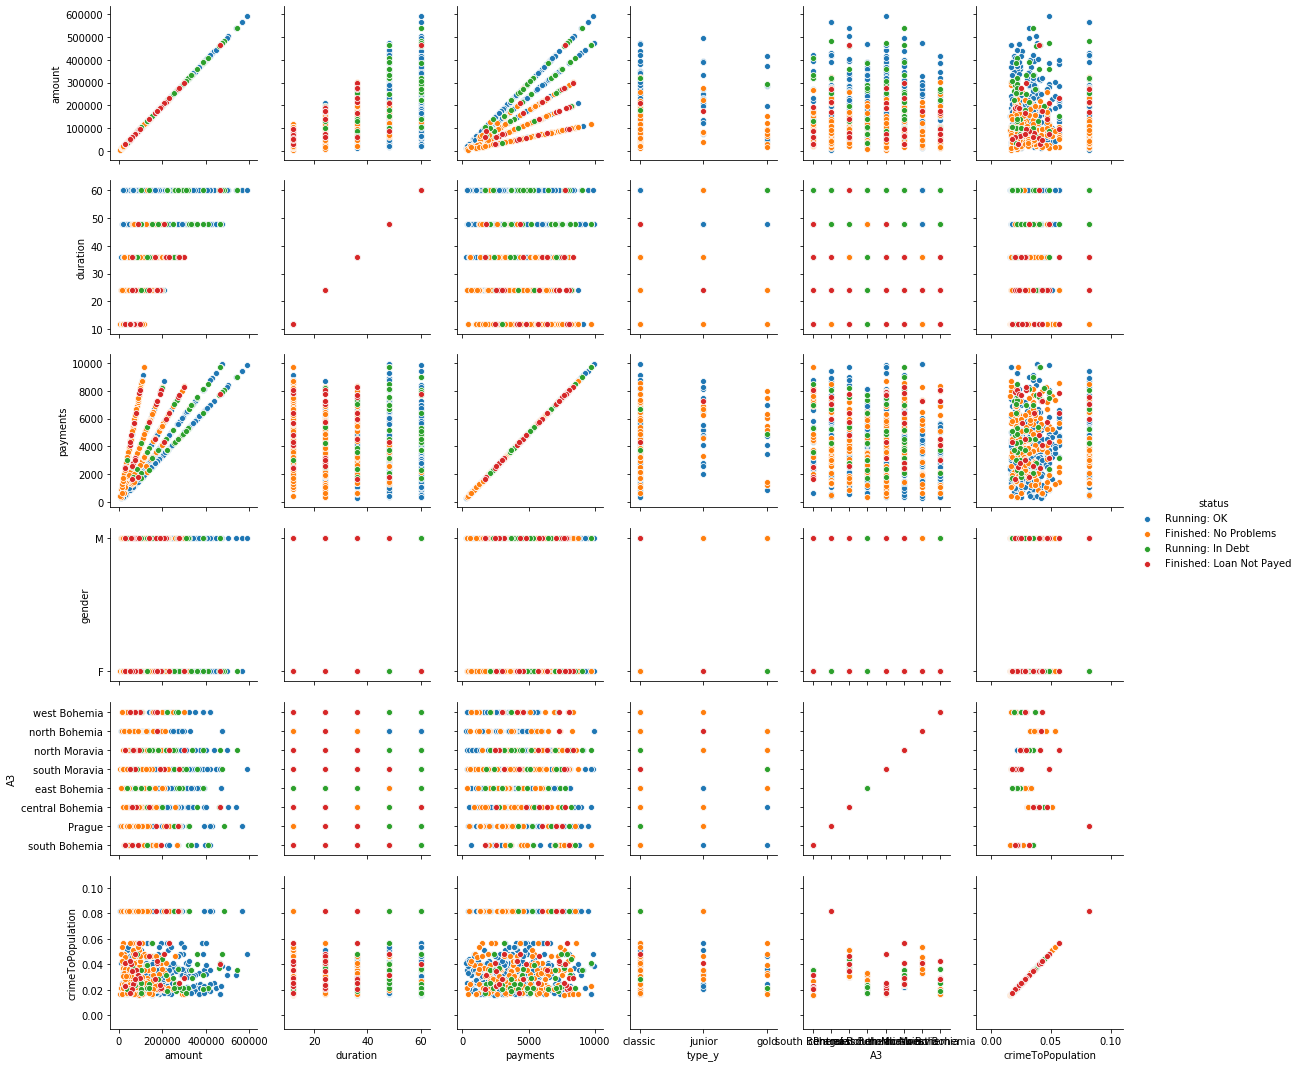

In [17]:
# 'amount' 'duration' 'payments' 'status' 'A2' 'gender' 'type'
acctForPairplot = acct_disposition_client_cardDF[['amount','duration','payments','A3','gender','type_y', 'status', 'A4', 'A16']]
acctForPairplot['crimeToPopulation'] = acctForPairplot['A16']  / acctForPairplot['A4'] 
sns.pairplot(data=acctForPairplot,
             x_vars=['amount','duration','payments','type_y', 'A3', 'crimeToPopulation'],
             y_vars=['amount','duration', 'payments','gender', 'A3', 'crimeToPopulation'],
             hue='status')

Looking at the above pairplot, we can see some quickly visualized data. One of the first things to jump out of this pairplot is that as amounts of the loans grow, the more likely it is to see that a loan's status move from finished to running. We can additionally see that as the amount of the loan increases, the payments of the loan also suggest that the loan is still running. This is all to be expected. 

The graph with respect to the crime rates per capita are interesting, particularly in that they don't appear to have much of an effect on the loan statuses. We additionally don't appear to see any immediately extractable difference in payments either. 

We additionally can see there exist many columns in our data that are categorical in nature. With this particular type of plot, we cannot easily discern what datapoints are all on those categorical points (given that they overlap and we see only the last placed). In order to more granularly search the data, we ought to explore the data feature by feature with respect to our loan data. 

### Loans By Gender

At first glance of the data, we have near equal amounts of male and femal clients. It could be curious to see if there were any drastic differences between the loan data for them: 

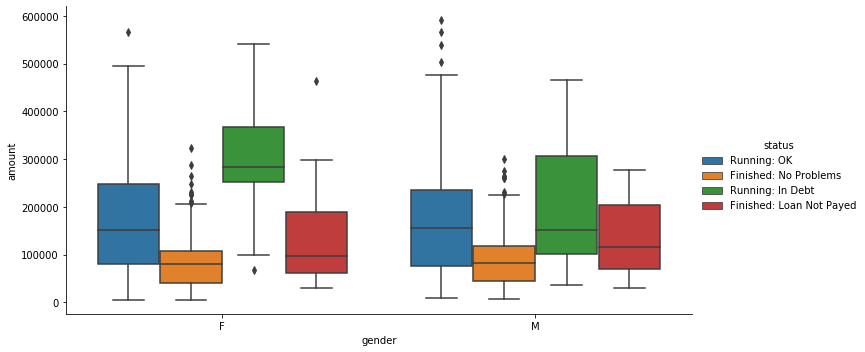

In [18]:
hueOrder = ['Running: OK', 'Finished: No Problems', 'Running: In Debt', 'Finished: Loan Not Payed']
chart2 = sns.catplot(data=acct_disposition_client_cardDF, x='gender', y='amount',  hue='status', kind='box', height=5, aspect=2, hue_order=hueOrder)

Using box plots, it appears that male and female clients tend to have similar types of loans and amounts of loaned money in each status category. Granted, it does appear that female clients tend to have accounts _Running: In Debt_ with a smaller variance than do male clients. Though the accounts look similar, let's attempt to see if there exist differences in the frequency: 


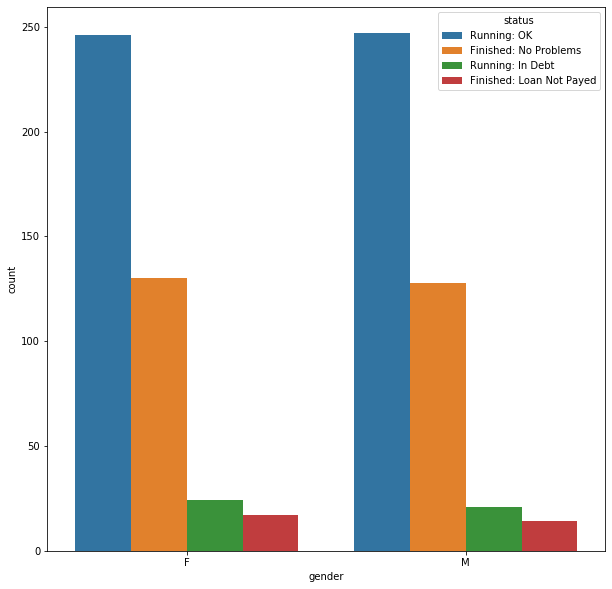

In [19]:
plt.figure(figsize=(10,10))
chart = sns.countplot(data=acct_disposition_client_cardDF, x='gender', hue='status', hue_order=hueOrder )

By distinguishing between the gender of the clients, we don't exactly see much of any difference in loan patterns. Let's instead attempt a different approach

### Loans By Region

Suppose we wished to know how individuals treaed bank loans by region. While we know that loan defaulting and debt are relatively low, they do still affect the bottom line. It would be useful to know know if there did exist geographical regions that expressed one characteristic over the other: 

<Figure size 720x720 with 0 Axes>

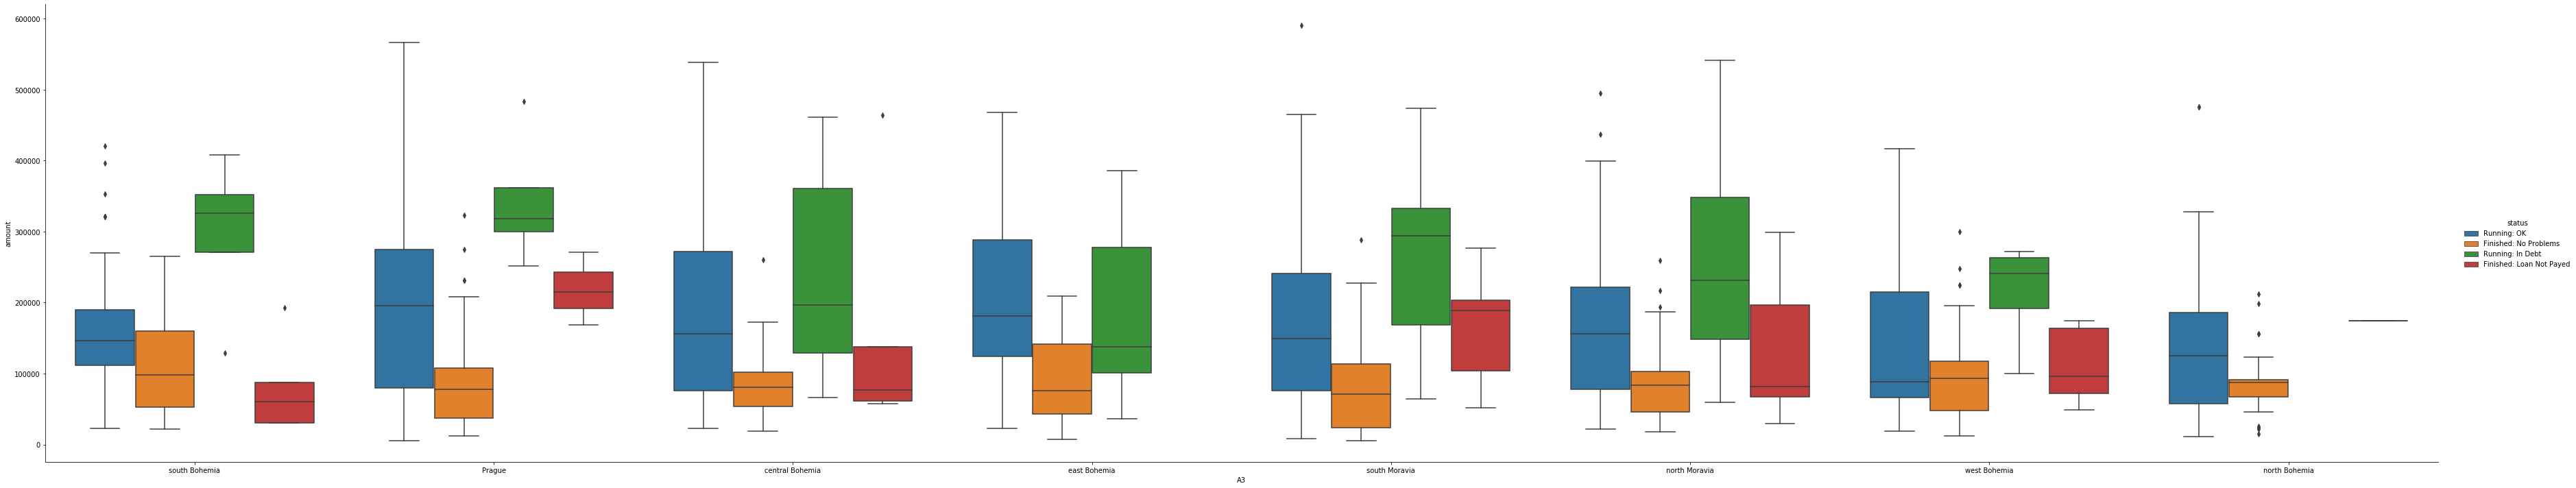

In [20]:
plt.figure(figsize=(10,10))
chart = sns.catplot(data=acct_disposition_client_cardDF, x='A3', y='amount',  hue='status', kind='box', height=10, aspect=5, hue_order=hueOrder )

From the above, we can see that each region has a reasonable spread of their account statuses, though at first glace, it appears that the most reasonable region to lend to would be North Bohemia, given that there appear to be no instances whatsoever of _Running: In Debt_ or _Finished: Loan Not Payed_. Granted, box plots are not to be used for the frequency of data, but instead  the data mapped are the 4 possible loan statuses as box plots, showing interquartile range as the colored box, with the extended lines denoting the min and max values.

To illustrate count, we can instead use count plots: 

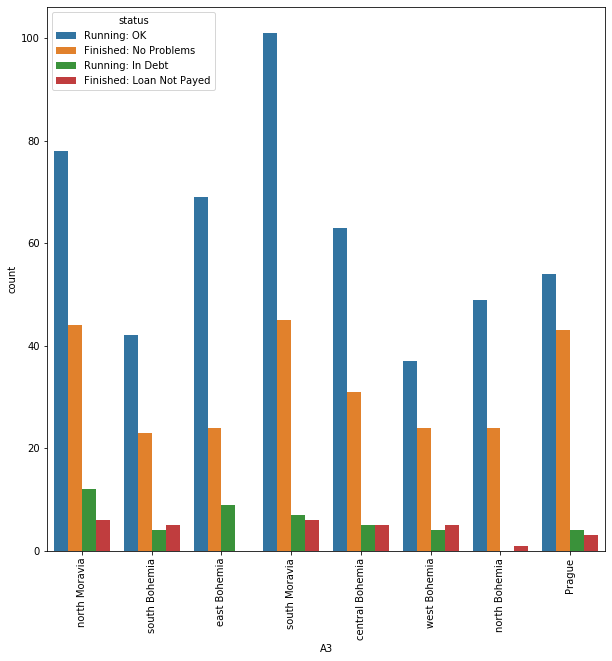

In [21]:
plt.figure(figsize=(10,10))
chart = sns.countplot(data=acct_disposition_client_cardDF.sort_values(by=['A11']), x='A3', hue='status', hue_order=hueOrder )
labels = chart.get_xticklabels()
lableChart = chart.set_xticklabels(labels, rotation=90)

Given the above plot, we can see that data illustrate the number of accounts that are _Running: OK, Finished: No Problems, Running: In Debt,_ and _Finished: Loan Not Payed_ by region. We can see that there is clearly a difference in what is illustrated from our above box plot. Note that North Bohemia does in fact have an instance  of an account that is _Finished: Loan Not Payed_. 

While North Bohemia does appear to have the lowest incidence of _Running: In Debt_ and _Finished: Loan Not Payed_ , we can see that even though South Moravia has higher instances of _Running: In Debt_ and _Finished: Loan Not Payed,_ it has nearly double the _Running: OK_ and _Finished: No Problems._ As a person looking to maximize profits, when taking into account the above box plots concerning South Moravia and North Bohemia, the size of the loans from South Moravia are generall greater than those of North Bohemia. Because of this, it ought to be reasonably suggested that more loans are offered in South Moravia. 

Granted, the size of the loans that are _Running: In Debt_ or _Finished: Loan Not Payed_ do find themselves being significantly greater than those of North Bohemia, but the vastly greater number of _Running: OK_ or _Finished: No Problems_ suggests that the risk could be acceptable. 


### Loans By District

Seeing what we have seen above, let's get a little more granular and see if we can derive any more information if we instead plot data by district: 

<Figure size 1440x1440 with 0 Axes>

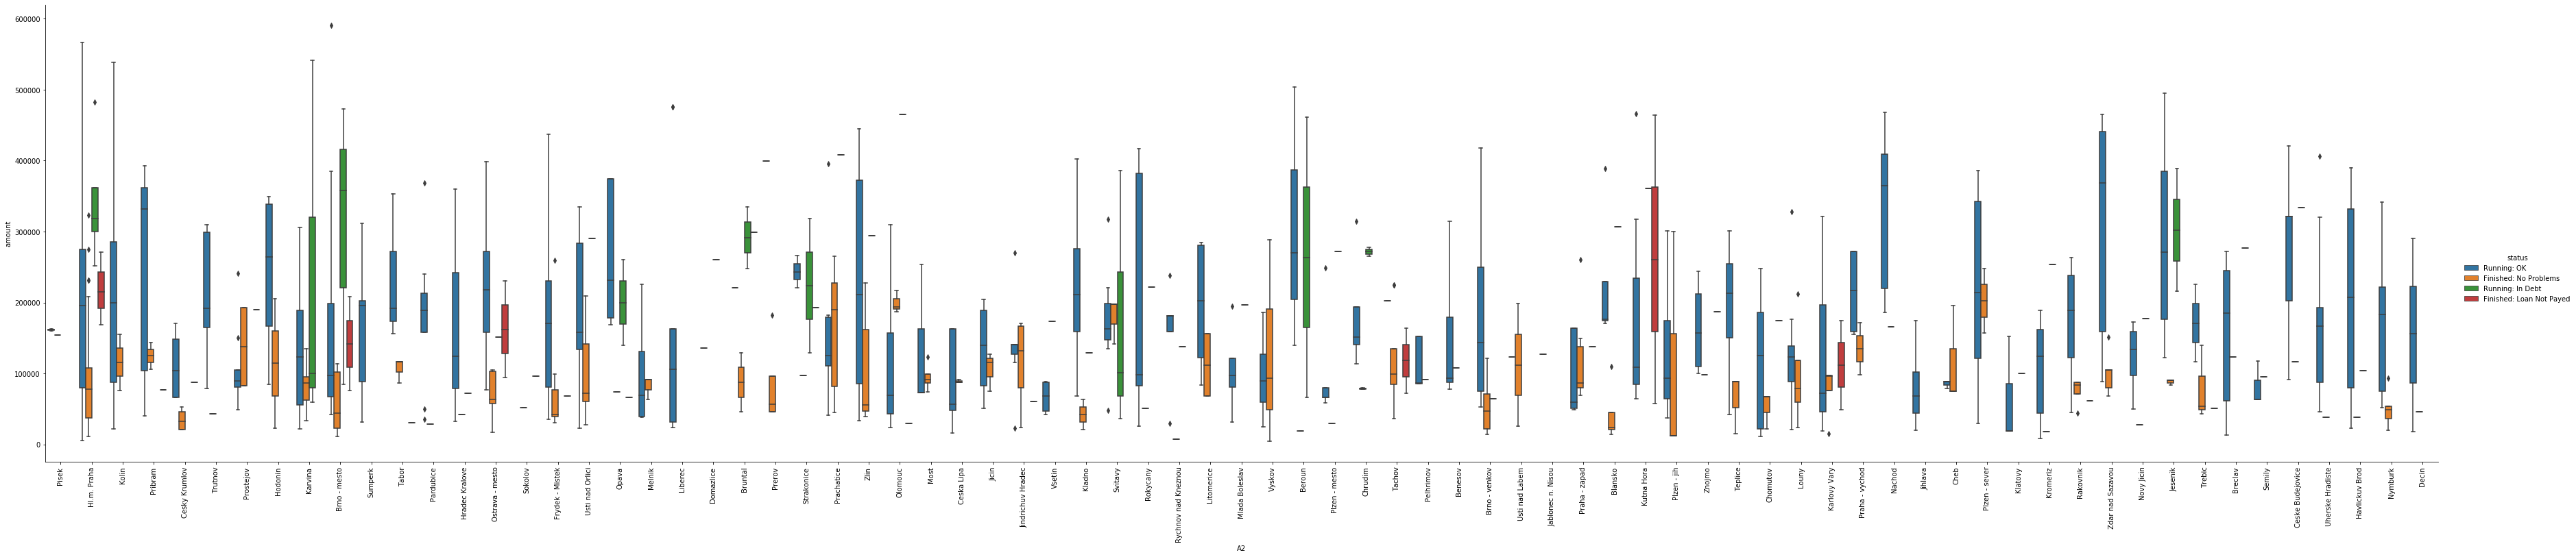

In [22]:
plt.figure(figsize=(20,20))
hueOrder = ['Running: OK', 'Finished: No Problems', 'Running: In Debt', 'Finished: Loan Not Payed']
chart = sns.catplot(data=acct_disposition_client_cardDF, x='A2', y='amount',  hue='status', kind='box', height=10, aspect=5, hue_order=hueOrder )
chart.set_xticklabels(rotation=90)

In the above figure, we have the vertical axis as the amount of each loan, and the horizontal axis is each particular district.

As was seen previously via the numbers, the vast majority of the data that we see are the blue and orange box plots, which associate with _Running: OK,_ and _Finished: No Problem_ respectively. Curiously, we can see a more detailed view of which regions have more individuals that are _Running: In Debt_ or _Finished: Loan Not Payed._ Our first intuition of the data ought to consider the average salary of each region. From this we may be able to draw more conclusions on our data: 

<Figure size 1440x1440 with 0 Axes>

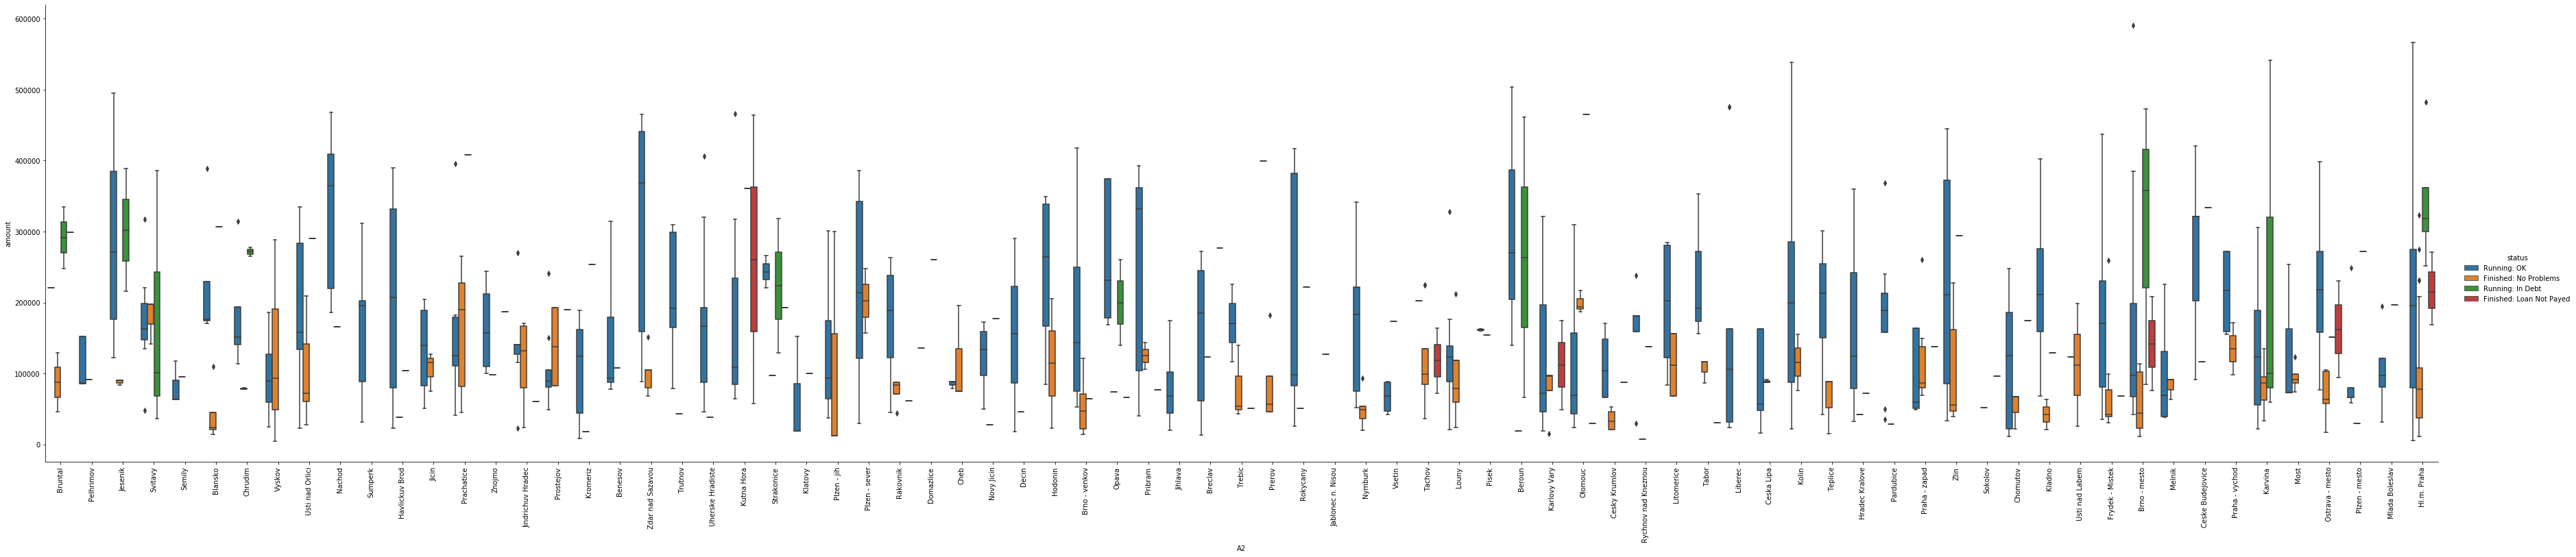

In [23]:
plt.figure(figsize=(20,20))
chart = sns.catplot(data=acct_disposition_client_cardDF.sort_values(by=['A11']), x='A2', y='amount',  hue='status', kind='box', height=10, aspect=5, hue_order=hueOrder )
chart.set_xticklabels(rotation=90)

In the above grid, districts are sorted such that their average salary increases across the horizontal axis. The average amount of the loans, surpsisingly, do not exactly appear to increase. What is most curious is that the difference between average salaries as noted above is: 
```
Total Average: 9519.221642764016
Maximum:  12541 	Region:  Hl.m. Praha
Minimum:  8110   	Region:  Bruntal
```
Taking that into account, it does not even appear that the median of each box plot exists in an increasing fashion. We do see that the maximum amount of loans given does tend to increase, but not overall. Let's map this data in another way where our salary is the horizontal axis: 

<Figure size 1440x1440 with 0 Axes>

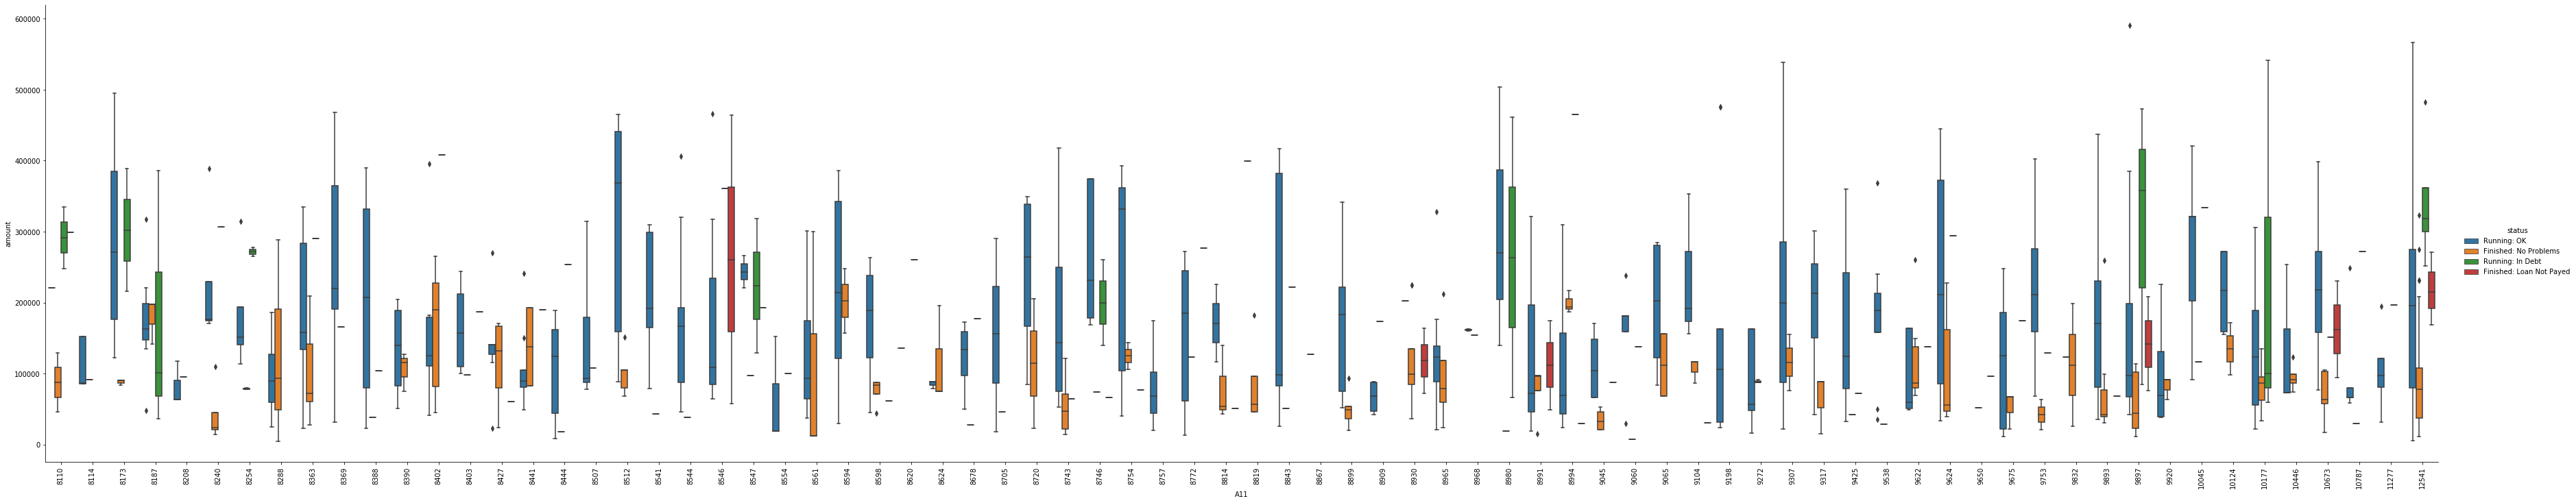

In [24]:
plt.figure(figsize=(20,20))
chart = sns.catplot(data=acct_disposition_client_cardDF.sort_values(by=['A11']), x='A11', y='amount',  hue='status', kind='box', height=10, aspect=5, hue_order=hueOrder )
chart.set_xticklabels(rotation=90)

In the above plot we can see that the average salary of the region does not exactly seem to illustrate trends in the amounts of the loans particularly placed. 

Let us instead use a countplot to see if there appears to exist a correlation between loans regions by population: 

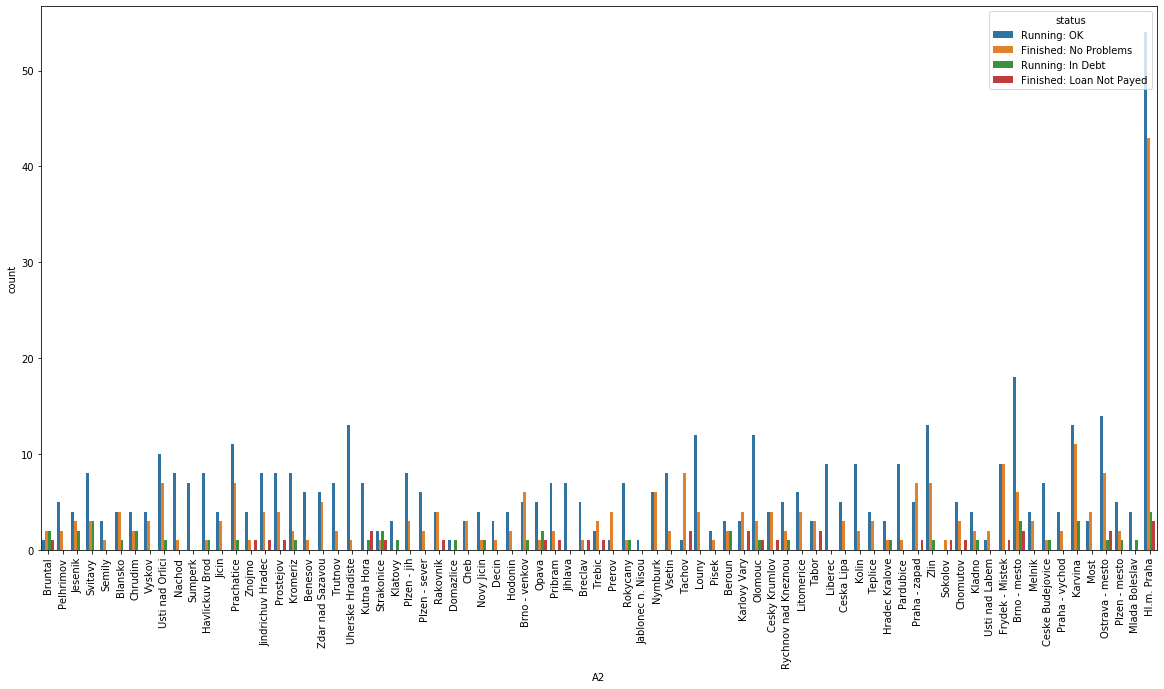

In [25]:
plt.figure(figsize=(20,10))
chart = sns.countplot(data=acct_disposition_client_cardDF.sort_values(by=['A11']), x='A2', hue='status', hue_order=hueOrder )
labels = chart.get_xticklabels()
lableChart = chart.set_xticklabels(labels, rotation=90)

Though Prague does have a larger amount accounts that are _Running: In Debt_ and _Finished: Loan Not Payed,_ proportionally speaking, those appear minor compared to the accounts _Running: OK_ and _Finished: No Problems_. Graphical information is helpful, but let's instead consider a chloropleth map to give us a more visual representation of our data.  

### Chloropleth Map

In order to do so, we need to use a shapefile of the regional and district data of the Czech repulplic. The shapefile was found from the [Berkeley Geodata library]("https://geodata.lib.berkeley.edu/catalog?f%5Bdc_format_s%5D%5B%5D=Shapefile&f%5Bdct_spatial_sm%5D%5B%5D=Czech+Republic&per_page=50&bbox=11.402781%2046.255847%2020.807078%2051.99841"). Given that the file is from a different repository, we need to do a little clean up before we can combine our datasets in that we then have to romanize some of the city names in order to properly match on our data. From there, we then will use Geopandas to display our data: 

In [26]:
def read_shapefile(sf):
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

def updateCzechNames(czechStr): 
    word = ''.join((c for c in unicodedata.normalize('NFD',czechStr) if unicodedata.category(c) != 'Mn'))
    
    if word == 'Plzen': return "Plzen - mesto"
    if word == 'Jablonec nad Nisou': return 'Jablonec n. Nisou'
    if word == 'Brno-Venkov': return 'Brno - venkov'
    if word == 'Brno': return 'Brno - mesto'
    if word == 'Frydek-Mistek': return 'Frydek - Mistek'
    if word == 'Ostrava': return 'Ostrava - mesto'
    
    return word

def getDataForPragueOrNan(series): 
    x = 0
    try: 
        x += series['Praha - vychod']
    except KeyError: 
        x = x

    try: 
        x += series['Praha - zapad']
    except KeyError: 
        x = x
    
    if (x==0): 
        return np.nan
    
    return x

def updatePragueDataForDF(runninOK, runningInDebt, finishedOK, finishedInDebt, mapFinished_Running): 
    runOK = getDataForPragueOrNan(runninOK)
    runDebt = getDataForPragueOrNan(runningInDebt)
    finOK = getDataForPragueOrNan(finishedOK)
    finDebt = getDataForPragueOrNan(finishedInDebt)

    rowsToUpdate = [f"Praha {i}" for i in range(1,23)]
    colToUpdate = ['runningOK', 'runningDebt', 'finishedOK', 'finishedDebt']
    values = np.repeat( np.array([runOK, runDebt, finOK, finDebt])[None,:], len(rowsToUpdate), axis=0)
    
    mapFinished_Running.loc[rowsToUpdate, colToUpdate] = values

def associateColumnToRegion(mapDF, districtDF, newColumnName): 
    mapDF[newColumnName] = np.nan
    for i in np.arange(len(mapDF.index)):
        values = districtDF[districtDF['A2'] == mapDF.index[i]]['A4'].values
        
        if "Praha" in mapDF.index[i]:
            values = districtDF[districtDF['A2'] == 'Hl.m. Praha']['A4'].values
        
        if len(values) > 0: 
            mapDF.at[mapDF.index[i], newColumnName]=values[0]


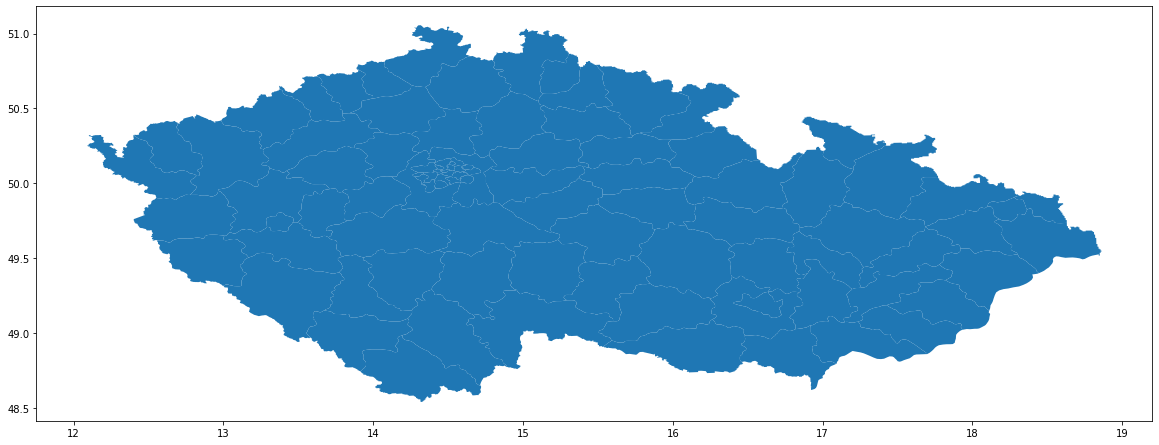

In [27]:
shp_path = "../data/geographicalData/CZE_adm2.shp"
sf = shp.Reader(shp_path)
czechShapeDF = read_shapefile(sf)

czechShapeDF['NAME_1'] = czechShapeDF['NAME_1'].apply(updateCzechNames)
czechShapeDF['NAME_2'] = czechShapeDF['NAME_2'].apply(updateCzechNames)

map_df=gpd.read_file(shp_path)

map_df['NAME_1'] = czechShapeDF['NAME_1']
map_df['NAME_2'] = czechShapeDF['NAME_2']
map_df.plot(figsize=(20,20), )

Above we see the geopandas representation of the Czech Republic with each region outlined in white. Before we do anything else, it would be elucidating to view the population centers of the Czech Republic.

Below data are manipulated for both population and Loan data. 

In [28]:
mapData = acct_disposition_client_cardDF[['A2', 'gender', 'status', 'amount']].dropna()
mapData.rename(columns={'A2': 'NAME_2'}, inplace=True)
mapData_Running_OK = mapData[mapData['status'] == 'Running: OK'].groupby('NAME_2')['status'].count()
mapData_Running_InDebt = mapData[mapData['status'] == 'Running: In Debt'].groupby('NAME_2')['status'].count()
mapData_Finished_OK = mapData[mapData['status'] == 'Finished: No Problems'].groupby('NAME_2')['status'].count()
mapData_Finished_InDebt = mapData[mapData['status'] == 'Finished: Loan Not Payed'].groupby('NAME_2')['status'].count()

mapWithRunningOK = map_df.set_index('NAME_2').join(mapData_Running_OK).rename(columns={"status": "runningOK"})
mapWithAllRunning = mapWithRunningOK.join(mapData_Running_InDebt).rename(columns={"status": "runningDebt"})
mapWithFinishedOK_Running = mapWithAllRunning.join(mapData_Finished_OK).rename(columns={"status": "finishedOK"})
mapFinished_Running = mapWithFinishedOK_Running.join(mapData_Finished_InDebt).rename(columns={"status": "finishedDebt"})

updatePragueDataForDF(mapData_Running_OK, mapData_Running_InDebt, mapData_Finished_OK, mapData_Finished_InDebt, mapFinished_Running)
associateColumnToRegion(mapFinished_Running, districtDF, 'POP')

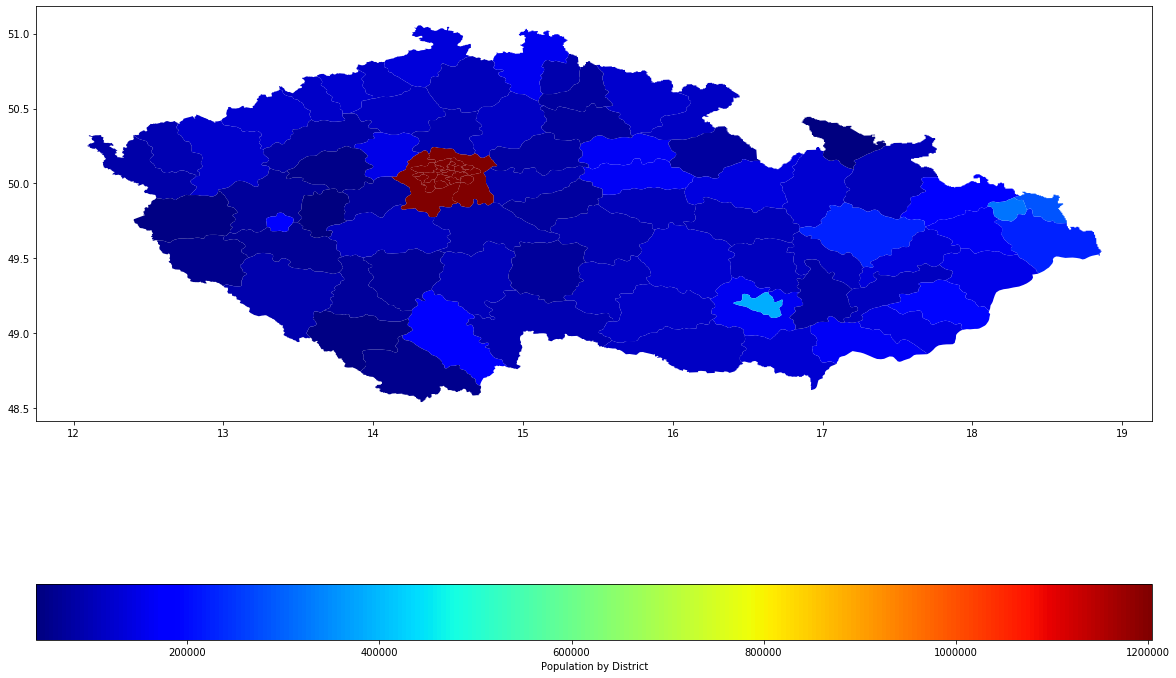

In [29]:
mapFinished_Running.plot(column='POP', cmap='jet', legend=True, legend_kwds={'label':'Population by District', 'orientation':'horizontal'}, figsize=(20,20))

The above map very clearly shows that the metropolitan region for Prague is significantly more populated than other regions, however we do see a much lighter blue around the region for Brno (seen around 49.1 N 16.5 E).

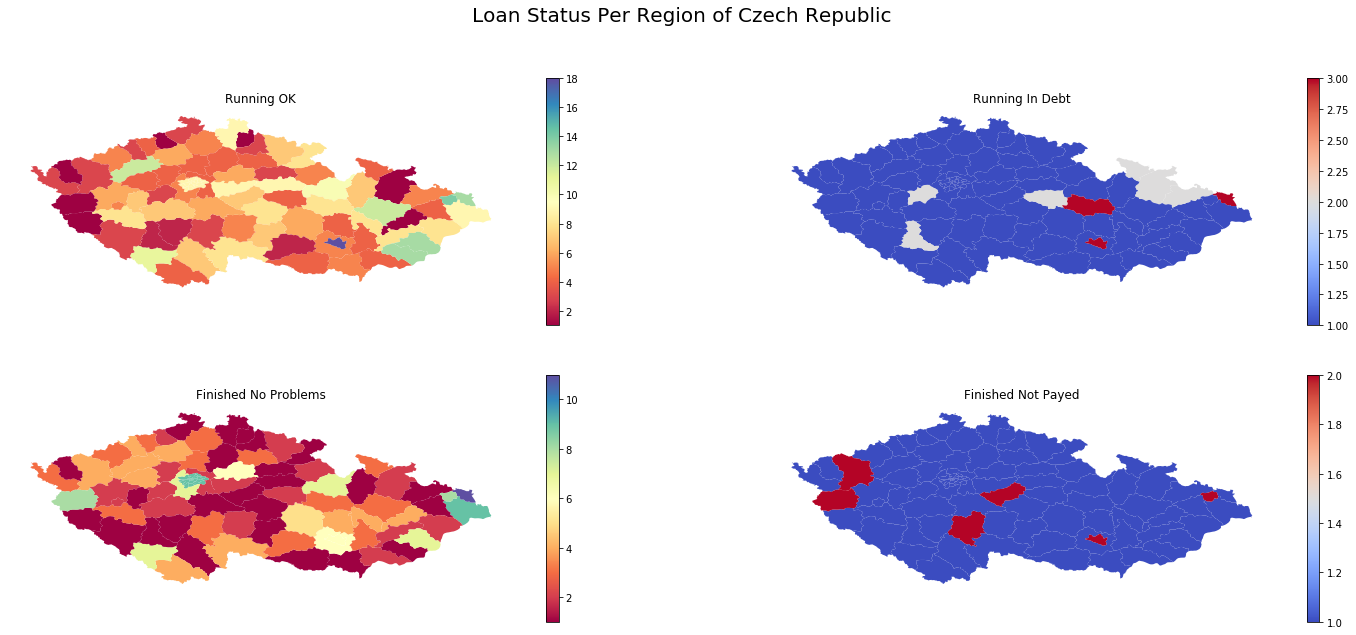

In [30]:
accountTitles = ["Running OK", "Running In Debt", "Finished No Problems", "Finished Not Payed"]
accountStatus = ['runningOK', 'runningDebt', 'finishedOK', 'finishedDebt']
cmapList = ['Spectral', 'coolwarm', 'Spectral', 'coolwarm']
f, axes = plt.subplots(2, 2, figsize=(25,10))
f.suptitle("Loan Status Per Region of Czech Republic", fontsize=20)
iterator = 0
for i in np.arange(len(axes)):
    for j in np.arange(len(axes[i])): 
        mapFinished_Running.plot(ax=axes[i][j] ,column=accountStatus[iterator], cmap=cmapList[iterator], legend=True )
        axes[i][j].set_title(accountTitles[iterator])
        axes[i][j].set_axis_off()
        iterator += 1


In the above we can see that the Brno region has a significant amount of _Running OK_ accounts, however, we can also see that same region has a higher level of _Finished Not Payed_ as well. Curiously, for the region of Prague that we saw earlier, we only see that it happens to have a higher rate of _Finished No problems_ comparatively speaking. 

## Further Data Exploration 

What we have done with this dataset is quite literally the tip of the iceberg. Given that we have transactional data, account summaries, regional demographics, we could create a machine learning model to categorize potential customers into classes on whether they'd be more likely to have an account that ran in debt, or possibly one that payed everything back on time, or whether or not the potential customers would fully repay their loans at all. 

While we were able to see some curious data from the box plots and chloropleth maps, it would be curious if each account had an individual salaray associated to it. Additionally, while we do have a fair amount of samples, when breaking the data up to be regional, the number of samples per region becomes potentially too few. More data are always appreciated! 